# Install the library
after that restart the runtime before continuing with the next block of code

In [ ]:
!sudo apt-get install build-essential swig
!curl https://raw.githubusercontent.com/automl/auto-sklearn/master/requirements.txt | xargs -n 1 -L 1 pip install
!pip install auto-sklearn
!pip install pandas_profiling -U
!pip install shap

#Import all libraries needed


In [2]:
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling as pp
import sklearn.preprocessing as prep
import sklearn.model_selection as ms
#import imblearn.combine as cb # got dependency issue
import sklearn.linear_model as lm
import sklearn.svm as svm
import sklearn.ensemble as ens
import sklearn.pipeline as pl
import sklearn.metrics as mtr
import shap
import autosklearn.metrics as asm
from autosklearn.classification import AutoSklearnClassifier

Possible set intersection at position 3


#Load the dataset to dataframe

In [3]:
ds = pd.read_csv('Data Exercise - Customer Churn.csv')
ds

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,1,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,2,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,4,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,5,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,7039,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,7040,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,7041,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,7042,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


#Perform EDA

In [ ]:
pp.ProfileReport(ds)

Summarize dataset:   0%|          | 0/34 [00:00<?, ?it/s]

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

#Remove records with missing values in column TotalCharges

In [4]:
print(ds.shape)
ds = ds.query("TotalCharges != ' '").reset_index(drop=True)
ds = ds.query("TotalCharges != ''").reset_index(drop=True)
print(ds.shape)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


(7043, 21)
(7032, 21)


#Transform 2 categorical values to numeric using encoder

In [ ]:
ds2 = ds.iloc[:,:]
#gender
gender_le = prep.LabelEncoder()
ds2['gender_Male'] = gender_le.fit_transform(ds2['gender'])

#SeniorCitizen
sr_ctzn_le = prep.LabelEncoder()
ds2['SeniorCitizen_Yes'] = sr_ctzn_le.fit_transform(ds2['SeniorCitizen'])

#Partner
partner_le = prep.LabelEncoder()
ds2['Partner_Yes'] = partner_le.fit_transform(ds2['Partner'])

#Dependents
dependents_le = prep.LabelEncoder()
ds2['Dependents_Yes'] = dependents_le.fit_transform(ds2['Dependents'])

#PhoneService
ph_svc_le = prep.LabelEncoder()
ds2['PhoneService_Yes'] = ph_svc_le.fit_transform(ds2['PhoneService'])

#PaperlessBilling
ppl_bill_le = prep.LabelEncoder()
ds2['PaperlessBilling_Yes'] = ppl_bill_le.fit_transform(ds2['PaperlessBilling'])

#Churn
churn_le = prep.LabelEncoder()
ds2['Churn_Yes'] = churn_le.fit_transform(ds['Churn'])

ds2.shape

(7032, 28)

#Transform other categorical values using encoder

In [ ]:
ohe = prep.OneHotEncoder()
column_names = ['MultipleLines', 'InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies','PaymentMethod','Contract']
encoded_arr = ohe.fit_transform(ds2[column_names]).toarray()

column_labels = []
for col in ohe.categories_:
  prefix = column_names.pop(0) + '_'
  column_labels.extend([prefix + name for name in col.tolist()])

cat_ds = pd.DataFrame(encoded_arr,columns=column_labels)
ds2 = ds2.join(cat_ds)
ds2.shape

(7032, 59)

#Remove unused columns used for modelling

In [ ]:
unused_cols = ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents','PhoneService', \
               'MultipleLines', 'InternetService','OnlineSecurity', 'OnlineBackup', 'DeviceProtection', \
               'TechSupport','StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling','PaymentMethod', \
               'Churn', 'MultipleLines_No phone service', 'InternetService_No', 'OnlineSecurity_No internet service', \
               'OnlineBackup_No internet service', 'DeviceProtection_No internet service', 'TechSupport_No internet service', \
               'StreamingTV_No internet service', 'StreamingMovies_No internet service']

ds2 = ds2.drop(columns=unused_cols).astype('float64')
ds2.shape

(7032, 33)

#Plot correlation matrix

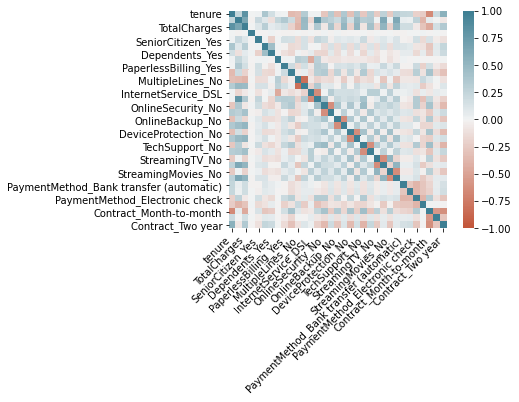

In [ ]:
corr = ds2.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

plt.show()

#Split dataset into train & test set

In [5]:
def trainTestSplit(data, labelName):
  y = data[labelName]
  X = data.drop(columns=[labelName])
  sss = ms.StratifiedShuffleSplit(n_splits=1, test_size=0.1)
  for train_index, test_index in sss.split(X, y):
    X_train, X_test = X.iloc[train_index,:].reset_index(drop=True), X.iloc[test_index,:].reset_index(drop=True)
    y_train, y_test = y[train_index], y[test_index]

  print("train set class 0:", len(y_train[y_train==0]), "class 1:", len(y_train[y_train==1]))
  print("test set class 0:", len(y_test[y_test==0]), "class 1:", len(y_test[y_test==1]))
  
  return X_train, y_train, X_test, y_test

In [ ]:
X_train, y_train, X_test, y_test = trainTestSplit(ds2, 'Churn_Yes')

#Standardize training data for columns with continuous numeric values


In [ ]:
qt = prep.QuantileTransformer( output_distribution='normal') 
X_train[['MonthlyCharges','tenure','TotalCharges']] = qt.fit_transform( X_train[['MonthlyCharges','tenure','TotalCharges']])
X_test[['MonthlyCharges','tenure','TotalCharges']] = qt.transform( X_test[['MonthlyCharges','tenure','TotalCharges']])
X_sampled, y_sampled = X_train, y_train

#Perform Cross Validation

In [ ]:
def cv(model, params, X, y, scoring = 'f1_weighted'):
  gs = ms.GridSearchCV(model, params, scoring=scoring ,n_jobs=-1, refit=scoring)
  gs.fit(X, y)
  result = gs.best_params_
  result['best_mean_score'] = gs.best_score_
  result['model_name'] = type(model)
  return result 


In [ ]:
cv_results = []

#Logistic Regression
params = {'C': [1,0.1,0.01]}
cv_results.append(cv(lm.LogisticRegression(), params, X_train, y_train))

#SVM is too slow
params = {'C': [1,0.1,0.01], 'kernel': ['rbf','linear']}
cv_results.append(cv(svm.SVC(), params, X_train, y_train))

#Random Forest
params = {'n_estimators': [100,500], 'max_depth':[None, 30], 'max_features':[None,'auto']}
cv_results.append(cv(ens.RandomForestClassifier(), params, X_train, y_train))

params = {'learning_rate': [0.1,0.3], 'n_estimators': [100,500], 'max_depth':[10,30]}
cv_results.append(cv(xgb.XGBClassifier(min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, objective= 'binary:logistic', scale_pos_weight=1), params, X_train, y_train))

cv_results

[{'C': 1,
  'best_mean_score': 0.8021231667621871,
  'model_name': sklearn.linear_model._logistic.LogisticRegression},
 {'C': 1,
  'best_mean_score': 0.7986698695932792,
  'kernel': 'linear',
  'model_name': sklearn.svm._classes.SVC},
 {'best_mean_score': 0.7821682677676153,
  'max_depth': None,
  'max_features': None,
  'model_name': sklearn.ensemble._forest.RandomForestClassifier,
  'n_estimators': 100},
 {'best_mean_score': 0.7833347746455152,
  'learning_rate': 0.1,
  'max_depth': 30,
  'model_name': xgboost.sklearn.XGBClassifier,
  'n_estimators': 100}]

Interestingly, the best model for unsampled data is Logistic Regression with 79.9% of F1-score, beating the ensemble classifiers.

# Perform Sampling for Imbalanced Training Data
(Skip this because of library problem)

In [ ]:
smt = cb.SMOTETomek(ratio='auto')
X_sampled, y_sampled = smt.fit_sample(X_train, y_train)
print("train set after sampling class 0:", len(y_sampled[y_sampled==0]), "class 1:", len(y_sampled[y_sampled==1]))


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


train set after sampling class 0: 4464 class 1: 4464


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


#Perform Cross Validation on Sampled Training Data
(Skip this because of library problem)

In [ ]:
cv_sampled_results = []

#Logistic Regression
params = {'C': [1,0.1,0.01]}
cv_sampled_results.append(cv(lm.LogisticRegression(), params, X_sampled, y_sampled))

#SVM is too slow
params = {'C': [1,0.1,0.01], 'kernel': ['rbf','linear']}
cv_sampled_results.append(cv(svm.SVC(), params, X_sampled, y_sampled))

#Random Forest
params = {'n_estimators': [100,500], 'max_depth':[None, 30], 'max_features':[None,'auto']}
cv_sampled_results.append(cv(ens.RandomForestClassifier(), params, X_sampled, y_sampled))

params = {'learning_rate': [0.1,0.3], 'n_estimators': [100,500], 'max_depth':[10,30]}
cv_sampled_results.append(cv(xgb.XGBClassifier(min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, objective= 'binary:logistic', scale_pos_weight=1), params, X_sampled, y_sampled))

cv_sampled_results

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


[{'C': 0.01,
  'best_mean_score': 0.7910482436624686,
  'model_name': sklearn.linear_model._logistic.LogisticRegression},
 {'C': 1,
  'best_mean_score': 0.8101570723434038,
  'kernel': 'rbf',
  'model_name': sklearn.svm._classes.SVC},
 {'best_mean_score': 0.8758281573312034,
  'max_depth': 30,
  'max_features': 'auto',
  'model_name': sklearn.ensemble._forest.RandomForestClassifier,
  'n_estimators': 500},
 {'best_mean_score': 0.8657773598288877,
  'learning_rate': 0.1,
  'max_depth': 30,
  'model_name': xgboost.sklearn.XGBClassifier,
  'n_estimators': 100}]

As expected, the performance of the models with sampled data is better than unsampled one (except logistic regression with only small difference), with random forest has highest F1-score. 

##The performance can be improved more by further tuning the hyperparameters and perhaps try to apply PCA, but due to time constraint, it can't be done in this test.

#Test the sampled models with best parameters to predict the test set

In [ ]:
def test(model, X, y, X_test, y_test):
  model.fit(X, y)
  y_pred = model.predict(X_test)

  disp = mtr.plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues)
  disp.ax_.set_title(type(model))
  plt.show()

  result = {'name': type(model)}
  result['accuracy'] = mtr.accuracy_score(y_test,y_pred)
  result['precision'] = mtr.precision_score(y_test,y_pred)
  result['recall'] = mtr.recall_score(y_test,y_pred)
  result['f1-score'] = mtr.f1_score(y_test,y_pred)
  result['prediction'] = y_pred
  return result

Predict the performance of each model

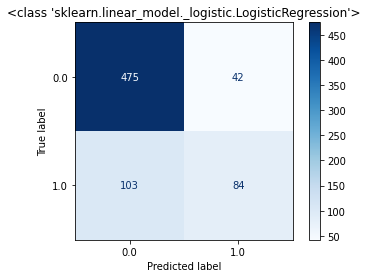

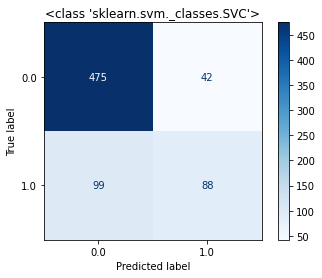

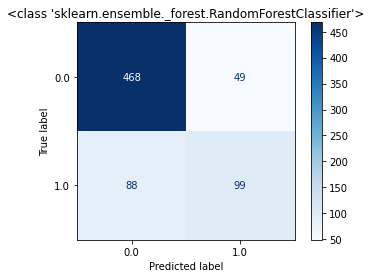

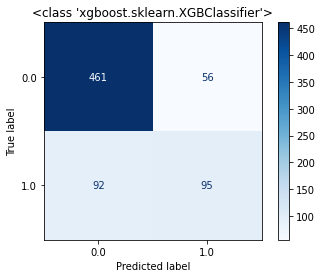

,name,accuracy,precision,recall,f1-score
0,<class 'sklearn.linear_model._logistic.Logisti...,0.794034,0.666667,0.449198,0.536741
1,<class 'sklearn.svm._classes.SVC'>,0.799716,0.676923,0.470588,0.555205
2,<class 'sklearn.ensemble._forest.RandomForestC...,0.805398,0.668919,0.529412,0.591045
3,<class 'xgboost.sklearn.XGBClassifier'>,0.789773,0.629139,0.508021,0.562130


In [ ]:
results = []

results.append(test(lm.LogisticRegression(C=0.01, n_jobs=-1), X_sampled, y_sampled, X_test, y_test))
results.append(test(svm.SVC(C=1, kernel= 'rbf'), X_sampled, y_sampled, X_test, y_test))
results.append(test(ens.RandomForestClassifier(n_estimators=500, max_depth=30, max_features='auto', n_jobs=-1), X_sampled, y_sampled, X_test, y_test))
results.append(test(xgb.XGBClassifier(n_estimators= 100, learning_rate= 0.1, max_depth= 30, n_jobs=-1, min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, objective= 'binary:logistic', scale_pos_weight=1), X_sampled, y_sampled, X_test, y_test))


df_results = pd.DataFrame(results).drop(columns=['prediction'])
df_results

#Show feature importance with shap values

Use XGBoost as a sample to show feature importance

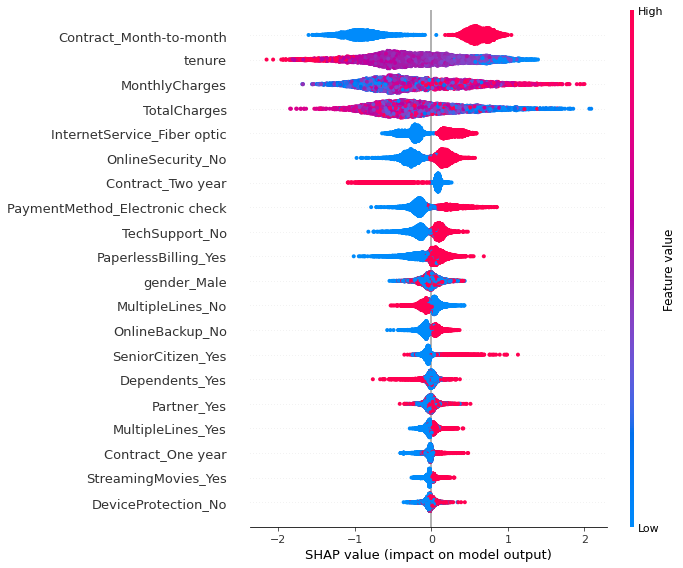

In [ ]:
model = xgb.XGBClassifier(n_estimators= 100, learning_rate= 0.1, max_depth= 30, n_jobs=-1, min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, objective= 'binary:logistic', scale_pos_weight=1)
model.fit(X_sampled, y_sampled)
shap_values = shap.TreeExplainer(model).shap_values(X_sampled)
shap.summary_plot(shap_values, X_sampled)
#taking long time to produce the plot

# Try with Auto-Sklearn
Update the column types

In [6]:
ds3 = ds.astype('category')
ds3['gender'] = ds3['gender'].apply(lambda x: True if x == "Male" else False).astype('boolean')
ds3['Partner'] = ds3['Partner'].apply(lambda x: True if x == "Yes" else False).astype('boolean')
ds3['Dependents'] = ds3['Dependents'].apply(lambda x: True if x == "Yes" else False).astype('boolean')
ds3['PhoneService'] = ds3['PhoneService'].apply(lambda x: True if x == "Yes" else False).astype('boolean')
ds3['OnlineSecurity'] = ds3['OnlineSecurity'].apply(lambda x: True if x == "Yes" else False).astype('boolean')
ds3['OnlineBackup'] = ds3['OnlineBackup'].apply(lambda x: True if x == "Yes" else False).astype('boolean')
ds3['DeviceProtection'] = ds3['DeviceProtection'].apply(lambda x: True if x == "Yes" else False).astype('boolean')
ds3['TechSupport'] = ds3['TechSupport'].apply(lambda x: True if x == "Yes" else False).astype('boolean')
ds3['StreamingTV'] = ds3['StreamingTV'].apply(lambda x: True if x == "Yes" else False).astype('boolean')
ds3['StreamingMovies'] = ds3['StreamingMovies'].apply(lambda x: True if x == "Yes" else False).astype('boolean')
ds3['PaperlessBilling'] = ds3['PaperlessBilling'].apply(lambda x: True if x == "Yes" else False).astype('boolean')
ds3['Churn'] = ds3['Churn'].apply(lambda x: 1 if x == "Yes" else 0).astype('int64')
ds3['SeniorCitizen'] = ds3['SeniorCitizen'].astype('boolean')
ds3['tenure'] = ds3['tenure'].astype('float64')
ds3['MonthlyCharges'] = ds3['MonthlyCharges'].astype('float64')
ds3['TotalCharges'] = ds3['TotalCharges'].astype('float64')
ds3 = ds3.drop(columns=['customerID'])
ds3

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,False,False,True,False,1.0,False,No phone service,DSL,False,True,False,False,False,False,Month-to-month,True,Electronic check,29.85,29.85,0
1,True,False,False,False,34.0,True,No,DSL,True,False,True,False,False,False,One year,False,Mailed check,56.95,1889.50,0
2,True,False,False,False,2.0,True,No,DSL,True,True,False,False,False,False,Month-to-month,True,Mailed check,53.85,108.15,1
3,True,False,False,False,45.0,False,No phone service,DSL,True,False,True,True,False,False,One year,False,Bank transfer (automatic),42.30,1840.75,0
4,False,False,False,False,2.0,True,No,Fiber optic,False,False,False,False,False,False,Month-to-month,True,Electronic check,70.70,151.65,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,True,False,True,True,24.0,True,Yes,DSL,True,False,True,True,True,True,One year,True,Mailed check,84.80,1990.50,0
7028,False,False,True,True,72.0,True,Yes,Fiber optic,False,True,True,False,True,True,One year,True,Credit card (automatic),103.20,7362.90,0
7029,False,False,True,True,11.0,False,No phone service,DSL,True,False,False,False,False,False,Month-to-month,True,Electronic check,29.60,346.45,0
7030,True,True,True,False,4.0,True,Yes,Fiber optic,False,False,False,False,False,False,Month-to-month,True,Mailed check,74.40,306.60,1


Training the model

In [7]:
# split train & test set
X_train, y_train, X_test, y_test = trainTestSplit(ds3, 'Churn')
# create the model
model = AutoSklearnClassifier(time_left_for_this_task=150*60, per_run_time_limit=5*60, n_jobs=-1, memory_limit=4096, exclude_estimators=['k_nearest_neighbors', 'mlp', 'decision_tree'], resampling_strategy = 'cv',resampling_strategy_arguments= {'folds': 5, 'shuffle': True}, metric = asm.f1_weighted)
# training
model.fit(X_train, y_train)
# summarize
print(model.sprint_statistics())
print(model.show_models())

train set class 0: 4646 class 1: 1682
test set class 0: 517 class 1: 187
auto-sklearn results:
  Dataset name: d7592f2c-885b-11eb-82de-0242ac1c0002
  Metric: f1_weighted
  Best validation score: 0.798208
  Number of target algorithm runs: 210
  Number of successful target algorithm runs: 179
  Number of crashed target algorithm runs: 1
  Number of target algorithms that exceeded the time limit: 29
  Number of target algorithms that exceeded the memory limit: 1

[(0.120000, SimpleClassificationPipeline({'balancing:strategy': 'none', 'classifier:__choice__': 'lda', 'data_preprocessing:categorical_transformer:categorical_encoding:__choice__': 'no_encoding', 'data_preprocessing:categorical_transformer:category_coalescence:__choice__': 'no_coalescense', 'data_preprocessing:numerical_transformer:imputation:strategy': 'mean', 'data_preprocessing:numerical_transformer:rescaling:__choice__': 'quantile_transformer', 'feature_preprocessor:__choice__': 'feature_agglomeration', 'classifier:lda:shri

F1-score on test set: 0.5857988165680473


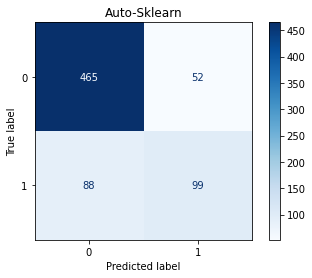

In [8]:
# make prediction
print("F1-score on test set:", mtr.f1_score (y_test,model.predict(X_test)))
disp = mtr.plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues)
disp.ax_.set_title('Auto-Sklearn')
plt.show()